In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

from shapely.geometry import Polygon

import iceplant_detection_functions as ipf

In [2]:
from imblearn.over_sampling import SMOTE

In [3]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','dangermond_and_campuspoint.csv')
features_df = pd.read_csv(fp)

In [4]:
features_df.drop(['geometry','Unnamed: 0','x','y','day','year'],axis=1,inplace=True)
ipf.iceplant_proportions(features_df.iceplant.to_numpy())

no-iceplant:iceplant ratio     1.6 :1
          counts  percentage
iceplant                    
0           8784       61.21
1           5567       38.79



In [5]:
train_features, test_features, train_labels, test_labels = ipf.test_train_from_df(features_df)

ipf.train_test_shapes(train_features, train_labels, test_features, test_labels)
ipf.test_train_proportions(train_labels, test_labels)

Training Features Shape: (10045, 5)
Training Labels Shape: (10045,)
Testing Features Shape: (4306, 5)
Testing Labels Shape: (4306,)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     1.6 :1
          counts  percentage
iceplant                    
0           6144       61.16
1           3901       38.84

TEST SET COUNTS:
no-iceplant:iceplant ratio     1.6 :1
          counts  percentage
iceplant                    
0           2640       61.31
1           1666       38.69



In [7]:
rfc = RandomForestClassifier(n_estimators = 150, 
                                      random_state = 42)
rfc.fit(train_features,train_labels)
predictions = rfc.predict(test_features)
ipf.print_rfc_evaluation(rfc, test_features, test_labels, predictions)


true negatives: 2613     false positives: 27
false negatives: 39     true positives: 1627

sensitivity (TP rate): 97.66 %
specificity (TN rate): 98.98 %
G-mean:  0.98

MCC:  0.9676658314128461

F1-measure:  0.98012
F0.5-measure (min false positives):  0.98225
F2-measure (min false negatives)  :  0.978

accuracy: 98.47 %



In [6]:
rfc_balanced = RandomForestClassifier(n_estimators = 150, 
                                      random_state = 42,
                                      class_weight='balanced')
rfc_balanced.fit(train_features,train_labels)
predictions_balanced = rfc_balanced.predict(test_features)
ipf.print_rfc_evaluation(rfc_balanced, test_features, test_labels, predictions_balanced)


true negatives: 2614     false positives: 26
false negatives: 39     true positives: 1627

sensitivity (TP rate): 97.66 %
specificity (TN rate): 99.02 %
G-mean:  0.98

MCC:  0.9681553843075748

F1-measure:  0.98042
F0.5-measure (min false positives):  0.98273
F2-measure (min false negatives)  :  0.97812

accuracy: 98.49 %



In [9]:
# create test and train sets with SMOTE

labels = np.array(features_df['iceplant'])
features = np.array(features_df.drop('iceplant', axis = 1))

oversample = SMOTE()
over_X, over_y = oversample.fit_resample(features, labels)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)

# ------------------------------------------------------------------------------------------

#Build SMOTE rfc model
SMOTE_srf = RandomForestClassifier(n_estimators=150, 
                                   random_state=42)
#Train SMOTE rfc
SMOTE_srf.fit(over_X_train, over_y_train)

SMOTE_predictions = SMOTE_srf.predict(test_features)

ipf.print_rfc_evaluation(SMOTE_srf, test_features, test_labels, SMOTE_predictions)


true negatives: 2636     false positives: 4
false negatives: 4     true positives: 1662

sensitivity (TP rate): 99.76 %
specificity (TN rate): 99.85 %
G-mean:  1.0

MCC:  0.9960838881006948

F1-measure:  0.9976
F0.5-measure (min false positives):  0.9976
F2-measure (min false negatives)  :  0.9976

accuracy: 99.81 %



In [10]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
#Create Stratified K-fold cross validation

labels = np.array(features_df['iceplant'])
#Convert to numpy array
features = np.array(features_df.drop('iceplant', axis = 1))

cv = RepeatedStratifiedKFold(n_splits=10, 
                             n_repeats=3, 
                             random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate SRF model
scores = cross_validate(rfc, features, labels, scoring=scoring, cv=cv)

#Get average evaluation metrics
print('Mean f1: %.3f' % np.mean(scores['test_f1']))
print('Mean recall: %.3f' % np.mean(scores['test_recall']))
print('Mean precision: %.3f' % np.mean(scores['test_precision']))

NameError: name 'mean' is not defined

In [13]:
print('Mean f1: %.3f' % np.mean(scores['test_f1']))
print('Mean recall: %.3f' % np.mean(scores['test_recall']))
print('Mean precision: %.3f' % np.mean(scores['test_precision']))

Mean f1: 0.978
Mean recall: 0.978
Mean precision: 0.979


/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
/tmp/ipykernel_821/1512231525.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veg['month']=7   # manually add date


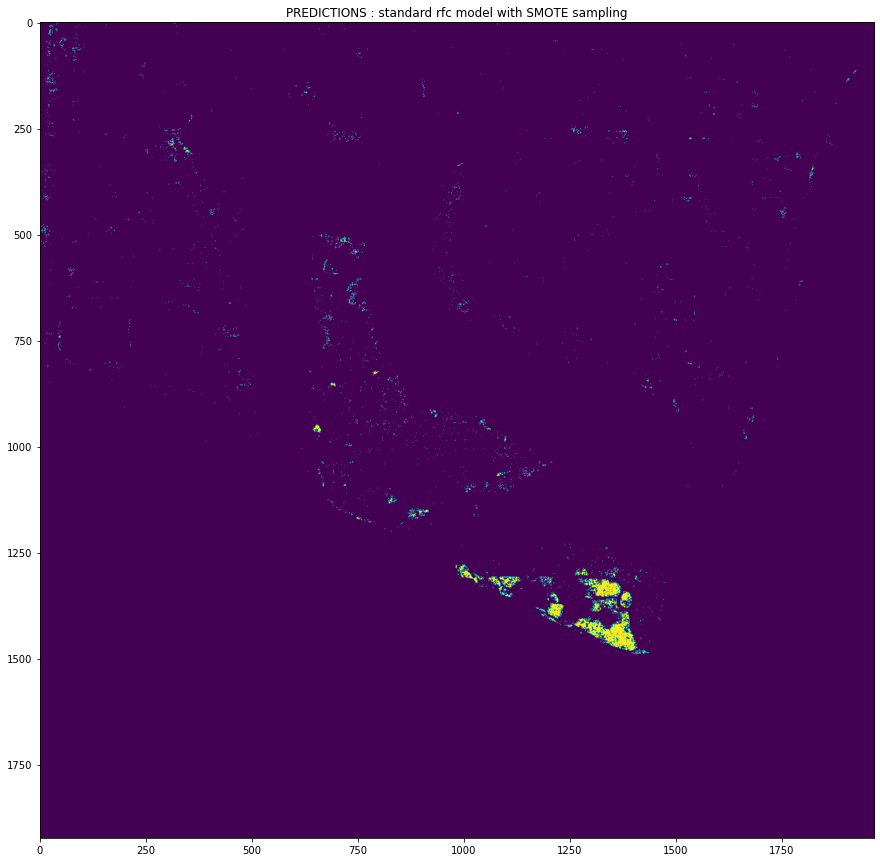

In [9]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
cp = aois.iloc[0]  # Campus Lagoon aoi

image = ipf.open_window_in_scene(cp.itemid, cp.geometry)
veg = ipf.select_ndvi_df(image)
veg['month']=7   # manually add date

index = veg.index
features = np.array(veg)

predictions_class = rfc_balanced.predict(features)

c = {'prediction':predictions_class}
predictions_df = pd.DataFrame(c, index = index)


predictions = ipf.df_backto_image(image,predictions_df)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : standard rfc model with SMOTE sampling")
ax.imshow(predictions)
plt.show()

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
/tmp/ipykernel_821/1488150894.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veg['month']=7   # manually add date


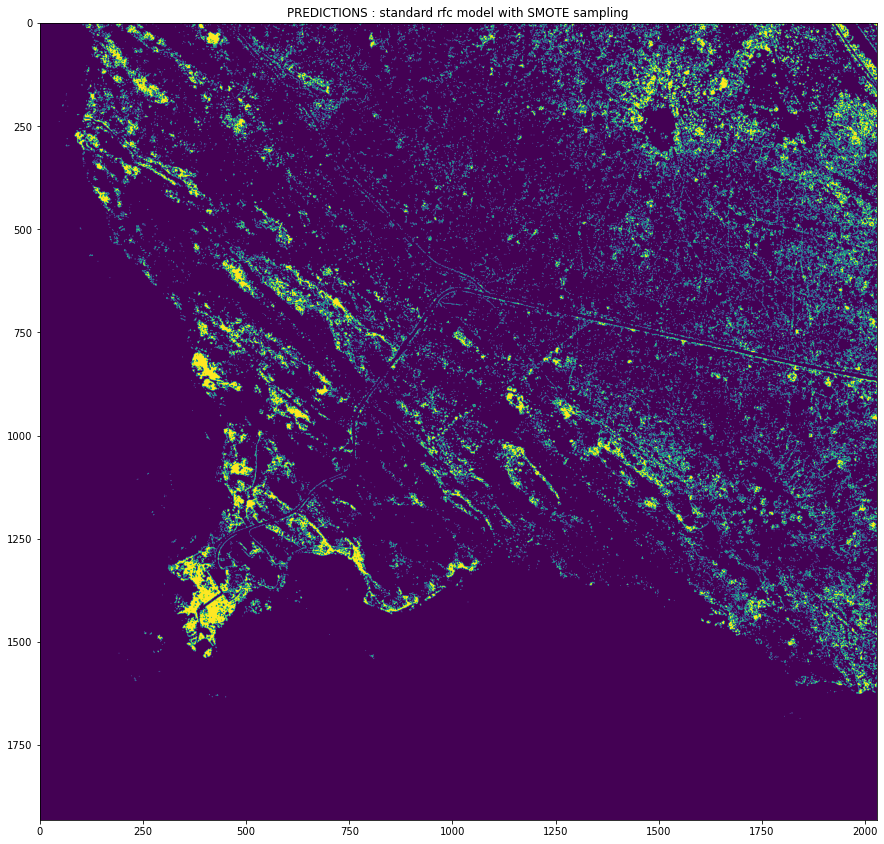

In [13]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
cp = aois.iloc[4]  # Campus Lagoon aoi

image = ipf.open_window_in_scene(cp.itemid, cp.geometry)
veg = ipf.select_ndvi_df(image)
veg['month']=9   # manually add date

index = veg.index
features = np.array(veg)

predictions_class = rfc_balanced.predict(features)

c = {'prediction':predictions_class}
predictions_df = pd.DataFrame(c, index = index)


predictions = ipf.df_backto_image(image,predictions_df)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : standard rfc model with SMOTE sampling")
ax.imshow(predictions)
plt.show()

In [8]:
aois

,name,itemid,geometry
0,campus point,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.85347 34.40287, -119.85347 34.4..."
1,campus lagoon zoom,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.85019 34.40848, -119.85019 34.4..."
2,campus lagoon tree,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.84943 34.40982, -119.84943 34.4..."
3,shoreline park,ca_m_3411935_sw_11_060_20180724_20190209,"POLYGON ((-119.71415 34.39310, -119.71415 34.3..."
4,conception point,ca_m_3412037_nw_10_060_20180913_20190208,"POLYGON ((-120.47317 34.44646, -120.47317 34.4..."
